In [ ]:


pip install torch torchvision pandas numpy pillow

In [12]:
# Part 1: Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
import os
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Unzip the file from Google Drive
!unzip /content/drive/My\ Drive/archive-2.zip -d /content/

In [13]:
# Part 2: Define Transforms
# Define data root based on your unzipped folder name
data_root = 'archive-2'  # Matches your directory name

# Function to convert images to RGB (handles grayscale to 3-channel conversion)
def to_rgb(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image

# Define transforms for training (with augmentation) and validation/testing (without augmentation)
train_transform = transforms.Compose([
    transforms.Lambda(to_rgb),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

val_transform = transforms.Compose([
    transforms.Lambda(to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

In [14]:
# Part 3: Load Datasets and Create DataLoaders
# Load the full training dataset without transforms initially
full_train_dataset = datasets.ImageFolder(os.path.join(data_root, 'train'))

# Split into training and validation sets (90% train, 10% validation)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Custom dataset class to apply transforms to subsets
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)
        return image, label

# Apply appropriate transforms to training and validation datasets
train_dataset = TransformedDataset(train_dataset, train_transform)
val_dataset = TransformedDataset(val_dataset, val_transform)

# Load the test dataset with validation transforms
test_dataset = datasets.ImageFolder(os.path.join(data_root, 'test'), transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Print dataset sizes to verify
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 25838
Validation dataset size: 2871
Test dataset size: 7178


In [15]:
# Part 4: Define the Model
# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Unfreeze layer4 for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace the final fully connected layer (7 classes for FER2013 emotions)
model.fc = nn.Linear(2048, 7)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


In [16]:
# Part 5: Training Loop with Early Stopping
num_epochs = 10  # Reduced for faster testing (originally 50)
best_accuracy = 0
patience = 3     # Reduced for faster stopping (originally 5)
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    # Early stopping logic
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print("Early stopping triggered")
            break

Epoch 1/10, Batch 100/404, Loss: 1.3886
Epoch 1/10, Batch 200/404, Loss: 1.1518
Epoch 1/10, Batch 300/404, Loss: 1.3310
Epoch 1/10, Batch 400/404, Loss: 0.8111
Epoch 1/10, Average Loss: 1.2196
Validation Accuracy: 62.21%
Epoch 2/10, Batch 100/404, Loss: 1.2811
Epoch 2/10, Batch 200/404, Loss: 1.0338
Epoch 2/10, Batch 300/404, Loss: 0.9942
Epoch 2/10, Batch 400/404, Loss: 0.8983
Epoch 2/10, Average Loss: 1.0195
Validation Accuracy: 64.16%
Epoch 3/10, Batch 100/404, Loss: 0.9923
Epoch 3/10, Batch 200/404, Loss: 1.0127
Epoch 3/10, Batch 300/404, Loss: 0.8496
Epoch 3/10, Batch 400/404, Loss: 1.0851
Epoch 3/10, Average Loss: 0.9406
Validation Accuracy: 65.24%
Epoch 4/10, Batch 100/404, Loss: 0.8137
Epoch 4/10, Batch 200/404, Loss: 0.8740
Epoch 4/10, Batch 300/404, Loss: 0.8399
Epoch 4/10, Batch 400/404, Loss: 1.1018
Epoch 4/10, Average Loss: 0.8819
Validation Accuracy: 67.36%
Epoch 5/10, Batch 100/404, Loss: 0.8622
Epoch 5/10, Batch 200/404, Loss: 0.7271
Epoch 5/10, Batch 300/404, Loss: 0.8

In [31]:
# Part 6: Evaluate on Test Set and Generate Metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import torch

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Initialize lists to store predictions and true labels
correct = 0
total = 0
all_preds = []
all_labels = []

# Evaluate on test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Your actual training data (from previous output)
train_losses = [1.2196, 1.0195, 0.9406, 0.8819, 0.8369, 0.8074, 0.7666, 0.7301, 0.6960, 0.6551]
val_accuracies = [62.21, 64.16, 65.24, 67.36, 67.22, 68.34, 68.20, 68.76, 69.00, 68.72]
epochs = range(1, 11)

# Save metrics to a CSV file for reproducibility
metrics_df = pd.DataFrame({
    'Epoch': list(epochs),
    'Training Loss': train_losses,
    'Validation Accuracy': val_accuracies
})
metrics_df.to_csv('training_metrics.csv', index=False)
print("Training metrics saved to 'training_metrics.csv'")

Test Accuracy: 67.67%
Training metrics saved to 'training_metrics.csv'


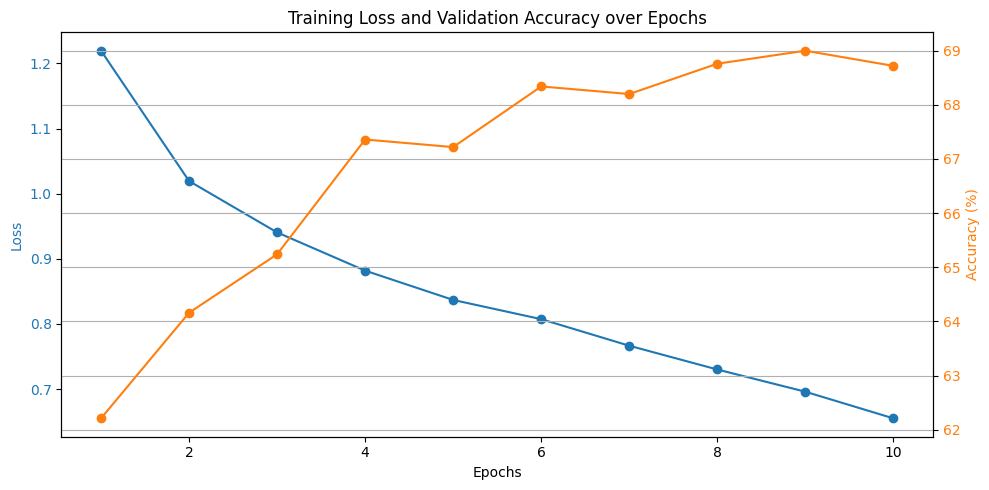

In [32]:
# Part 7: Plot Training Loss and Validation Accuracy (Combined)
fig, ax1 = plt.subplots(figsize=(10, 5))

# Training Loss
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, train_losses, label='Training Loss', marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Validation Accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:orange')
ax2.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and layout
plt.title('Training Loss and Validation Accuracy over Epochs')
fig.tight_layout()
plt.grid(True)
plt.savefig('loss_and_accuracy.png')
plt.show()

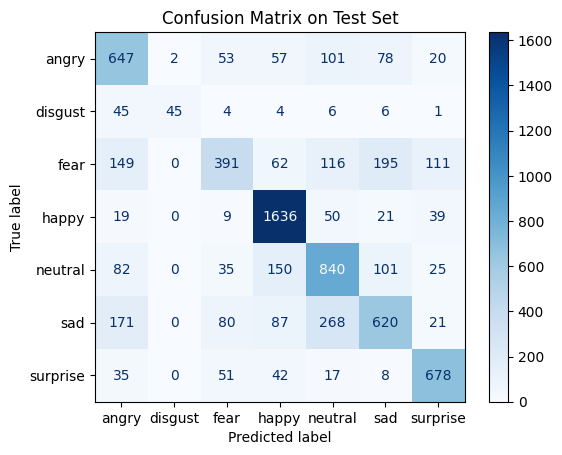

In [33]:
# Part 8: Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.savefig('confusion_matrix.png')
plt.show()


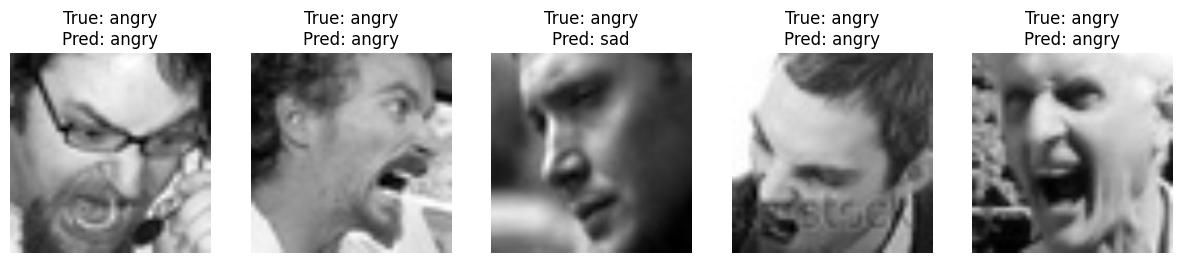

In [34]:
# Part 9: Visualize Sample Predictions
def show_predictions(model, dataloader, num_images=5):
    """
    Display a few test images with their true and predicted labels.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for the test set.
        num_images: Number of images to display (default: 5).
    """
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        axes[i].imshow(img)
        axes[i].set_title(f"True: {full_train_dataset.classes[labels[i]]}\nPred: {full_train_dataset.classes[preds[i]]}")
        axes[i].axis('off')
    plt.savefig('sample_predictions.png')
    plt.show()

# Call the function to show predictions
show_predictions(model, test_loader)

In [27]:
pip install matplotlib

In [35]:
# Part 10: Check Class-to-Index Mapping (Fixed)
print("Class to index mapping:", full_train_dataset.class_to_idx)

Class to index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
